In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union, Type, List
import numpy as np
import matplotlib.pyplot as plt

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# # PyTorch for Dataloaders
import torch

# JAX/Flax
import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn
import wandb

from visualization import visualize as vis
from data import data_functions as df
from models import model_architecture as march
from models import train_model as trm
from models import generate_model as gen

In [2]:
class DoubleDense(nn.Module):
    in_features: int
    hidden_features: int
    out_features: int

    def setup(self):
        self.dense1 = nn.Dense(self.hidden_features)
        self.dense2 = nn.Dense(self.out_features)

    def __call__(self, x):
        x = self.dense1(x)
        x = nn.gelu(x)
        x = self.dense2(x)
        return nn.gelu(x)

class Down(nn.Module):
    in_features: int
    out_features: int

    def setup(self):
        self.dense1 = DoubleDense(self.in_features, self.in_features, self.out_features)
        self.emb_layer = nn.Dense(self.out_features)

    def __call__(self, x, t):
        x = self.dense1(x)
        emb = self.emb_layer(t)
        return x + emb


class Up(nn.Module):
    in_features: int
    out_features: int

    def setup(self):
        self.dense1 = DoubleDense(self.in_features, self.in_features // 2, self.out_features)
        self.emb_layer = nn.Dense(self.out_features)

    def __call__(self, x, skip_x, t):
        x = jnp.concatenate([skip_x, x], axis=-1)
        x = self.dense1(x)
        emb = self.emb_layer(t)
        return x + emb


class UNet(nn.Module):
    in_features: int = 2
    out_features: int = 2
    std_data: float = 0.5

    def setup(self):
        self.inc = DoubleDense(self.in_features, 64, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)

        self.bot1 = DoubleDense(256, 512, 512)
        self.bot2 = DoubleDense(512, 512, 512)
        self.bot3 = DoubleDense(512, 256, 256)

        self.up1 = Up(512, 128)
        self.up2 = Up(256, 64)
        self.up3 = Up(128, 64)
        self.outc = nn.Dense(self.out_features)

    def __call__(self, x, t):
        t = t.squeeze()
        c_out = t * self.std_data / jnp.sqrt(self.std_data**2 + t**2)
        c_skip = self.std_data**2 / (self.std_data**2 + t**2)

        t = jnp.log(t.flatten()) / 4.
        t = self.pos_encoding(t, 64)
        x_orig = x

        x1 = self.inc(x) # 2 -> 64
        x2 = self.down1(x1, t) # 64 -> 128
        x3 = self.down2(x2, t) # 128 -> 256
        x4 = self.down3(x3, t) # 256 -> 256

        x4 = self.bot1(x4) # 256 -> 512
        x4 = self.bot2(x4) # 512 -> 512
        x4 = self.bot3(x4) # 512 -> 256

        x = self.up1(x4, x3, t) # 512 -> 128
        x = self.up2(x, x2, t) # 256 -> 64
        x = self.up3(x, x1, t) # 128 -> 64
        output = self.outc(x) # 2 -> 2

        # Reshape c_out & c_skip to match dimensions for broadcasting
        c_out = jnp.reshape(c_out, (-1,1))
        c_skip = jnp.reshape(c_skip, (-1,1))
        return c_out * output + c_skip * x_orig

    def pos_encoding(self, t, channels):
        t = jnp.expand_dims(t, axis=-1)  # Add an additional dimension to t
        inv_freq = 1.0 / (10000 ** (jnp.arange(0, channels, 2).astype(jnp.float32) / channels))
        pos_enc_a = jnp.sin(t * inv_freq)
        pos_enc_b = jnp.cos(t * inv_freq)
        pos_enc = jnp.concatenate([pos_enc_a, pos_enc_b], axis=-1)
        return pos_enc

In [3]:
# Generate dataset of 2D Gaussians
X = df.generate_data(43, 20000)
print(X.shape)

# Make the data suitable for a JAX Dataloader
train_dataset = df.JaxDataset(X=X)
train_loader = df.NumpyLoader(dataset=train_dataset,
                              batch_size=128,
                              shuffle=True)
batch = next(iter(train_loader))

# Create random array of noise to instantiate model to print model summary
model = UNet(in_features=2, out_features=2)
rng = random.PRNGKey(2)
rnd_normal = random.normal(rng, shape=(batch.shape[0], 1))
t = jnp.exp(rnd_normal * 1.2 - 1.2)
t = t.squeeze()
t = jnp.log(t.flatten()) / 4.

print(model.tabulate(jax.random.PRNGKey(9), batch, t))

(40000, 2)

                                            UNet Summary                                             
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path                ┃ module      ┃ inputs             ┃ outputs          ┃ params                ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│                     │ UNet        │ - float32[128,2]   │ float32[128,2]   │                       │
│                     │             │ - float32[128]     │                  │                       │
├─────────────────────┼─────────────┼────────────────────┼──────────────────┼───────────────────────┤
│ inc                 │ DoubleDense │ float32[128,2]     │ float32[128,64]  │                       │
├─────────────────────┼─────────────┼────────────────────┼──────────────────┼───────────────────────┤
│ inc/dense1          │ Dense       │ float32[128,2]     │ float32[128

# 3. Training Loop

In [4]:
config = {
    'seed': 47,
    'batch_size': 128,
    'learning_rate': 1e-4,
    'epochs': 20,
    'std_data': 0.5, 
    'in_features': 2,
    'out_features': 2,
    'D': 1024,
    'N': 2
}

# Get the rng & model instantiated
init_rng = random.PRNGKey(config['seed'])
model = UNet(in_features=config['in_features'],
             out_features=config['out_features'],
             std_data=config['std_data'])

# Sample the noise distribution
subkey4 = random.PRNGKey(32)
rnd_normal = random.normal(subkey4, shape=(batch.shape[0], 1))
t = jnp.exp(rnd_normal * 1.2 - 1.2)  

# Initialize the models state
state = trm.init_train_state(model=model,
                               random_key=init_rng,
                               x_shape=batch.shape,
                               t_shape=t.shape,
                               learning_rate=config['learning_rate'])

# Call the training function
model, state = trm.train_model(train_loader, model, state, config, wandb_logging=True)

KeyboardInterrupt: 

# 4. Sampling Loop

In [5]:
config = {'std_data': 0.5, 
          'in_features': 2,
          'out_features': 2}

# Get the rng & model instantiated
model = UNet(in_features=config['in_features'],
             out_features=config['out_features'],
             std_data=config['std_data'])  

batch = next(iter(train_loader))

updated_model = gen.load_checkpoint(ckpt_dir='PFGMPP/saved_models/toy/checkpoint_60.flax',
                                ckpt_file='checkpoint',
                                model=model)

In [16]:
samples, orig = gen.sample_loop(updated_model,
                                  num_steps=50,
                                  max_t=80,
                                  min_t=0.1,
                                  sample_size=20000,
                                  S_churn=0,
                                  S_min=0.01,
                                  S_max=2,
                                  S_noise=1,
                                  D=2048,
                                  N=2,
                                  rho=7,
                                  std_data=0.5,
                                  key_seed=43)

50it [00:09,  5.21it/s]


# 5. Visualize Generated Data

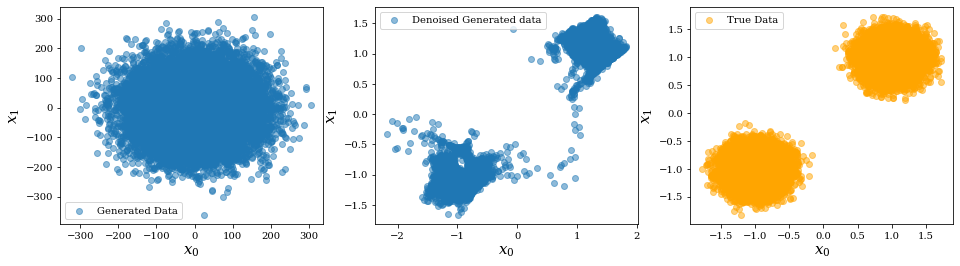

In [17]:
vis.sampling2D(prior_data=orig,
               true_data=X,
               sampled_data=samples,
               std=0.2,
               mean_scale=1)